In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q dash
!pip install -q jupyter-dash
!pip install -q dash-bootstrap-components
!pip install -q fredapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.2/221.2 kB 2.0 MB/s eta 0:00:00


In [ ]:
import scipy as sp
import seaborn as sns
import requests
import random
import io
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dask.dataframe as dd

In [ ]:
from fredapi import Fred
import pandas as pd
from datetime import datetime, date, time, timedelta
import time
import numpy as np
import re
import pickle

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet

import matplotlib.pyplot as plt

In [ ]:
from jupyter_dash import JupyterDash
from dash import Dash, html, dcc, Input, Output
import dash_bootstrap_components as dbc
from google.colab.output import eval_js
import IPython

In [ ]:
raw_data = dd.read_table('/content/drive/MyDrive/602-project/housing_market_data_most_recent.tsv000',
                         dtype={'adjusted_average_new_listings': 'float64',
                                'average_new_listings': 'float64',
                                'inventory': 'float64',
                                'total_new_listings': 'float64'})
print(f'Shape of data: {raw_data.shape}\n')

Shape of data: (Delayed('int-6942cc72-0f5b-4b5f-bad9-52a9477b8d10'), 102)



In [ ]:
raw_data.head()

,region_id,region_type_id,region_name,region_type,period_begin,period_end,duration,total_homes_sold,total_homes_sold_yoy,average_homes_sold,...,average_adjustment_average_homes_sold,adjusted_average_homes_sold,average_adjustment_average_new_listings,adjusted_average_new_listings,average_adjustment_pending_sales,adjusted_pending_sales,adjusted_average_homes_delisted_yoy,adjusted_average_homes_sold_yoy,adjusted_average_new_listings_yoy,adjusted_pending_sales_yoy
0,224,5,"Pinal County, AZ",county,2017-03-20,2017-03-26,1 weeks,172.0,0.005848,172.0,...,NaN,172.0,NaN,246.0,NaN,163.0,-0.312500,0.005848,0.205882,0.314516
1,224,5,"Pinal County, AZ",county,2017-01-02,2017-03-26,12 weeks,1870.0,0.171679,155.0,...,NaN,155.0,NaN,219.0,NaN,124.0,-0.228571,0.165414,-0.064103,0.180952
2,224,5,"Pinal County, AZ",county,2017-02-27,2017-03-26,4 weeks,812.0,0.262830,203.0,...,NaN,203.0,NaN,240.0,NaN,148.0,-0.257143,0.268750,0.137441,0.193548
3,250,5,"Faulkner County, AR",county,2017-03-20,2017-03-26,1 weeks,41.0,0.708333,41.0,...,NaN,41.0,NaN,38.0,NaN,24.0,0.000000,0.708333,0.187500,0.000000
4,250,5,"Faulkner County, AR",county,2017-01-02,2017-03-26,12 weeks,337.0,0.243542,28.0,...,NaN,28.0,NaN,38.0,NaN,20.0,0.000000,0.272727,-0.025641,0.176471


In [ ]:
url = r'https://www.redfin.com/stingray/api/gis-csv?al=1&market=socal&min_stories=1&num_homes=350&ord=redfin-recommended-asc&page_number=1&region_id=1669&region_type=6&sf=1,2,3,5,6,7&status=9&uipt=1,2,3,4,5,6,7,8&v=8'
file = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).content

df = pd.read_csv(io.StringIO(file.decode('utf-8')))
print(f'Shape of data: {df.shape}\n')


Shape of data: (351, 27)



In [ ]:
region_df = df.copy()
region_df.drop(region_df[region_df['CITY'] != 'Beverly Hills'].index, inplace=True)

region_df.head()

,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
1,MLS Listing,NaN,Single Family Residential,1633 N Beverly Dr,Beverly Hills,CA,90210.0,2899000.0,2.0,2.5,...,Active,NaN,NaN,https://www.redfin.com/CA/Beverly-Hills/1633-N...,CRMLS,SB23162677,N,Y,34.100374,-118.415783
2,MLS Listing,NaN,Condo/Co-op,221 S GALE Dr #405,Beverly Hills,CA,90211.0,1150000.0,2.0,2.0,...,Active,NaN,NaN,https://www.redfin.com/CA/Beverly-Hills/221-S-...,CRMLS,SR23222132,N,Y,34.063581,-118.374388
5,MLS Listing,NaN,Single Family Residential,1219 Beverly Estates Ter,Beverly Hills,CA,90210.0,3599999.0,2.0,3.0,...,Active,NaN,NaN,https://www.redfin.com/CA/Beverly-Hills/1219-B...,TheMLS,23-334161,N,Y,34.093027,-118.428676
6,MLS Listing,NaN,Single Family Residential,9736 Yoakum Dr,Beverly Hills,CA,90210.0,1795000.0,3.0,3.0,...,Active,NaN,NaN,https://www.redfin.com/CA/Beverly-Hills/9736-Y...,TheMLS,23-337711,N,Y,34.112432,-118.430754
8,MLS Listing,NaN,Single Family Residential,1420 Laurel Way,Beverly Hills,CA,90210.0,12900000.0,4.0,7.0,...,Active,NaN,NaN,https://www.redfin.com/CA/Beverly-Hills/1420-L...,TheMLS,23-337941,N,Y,34.097943,-118.417725


CITY
Beverly Hills    Axes(0.125,0.11;0.775x0.77)
dtype: object

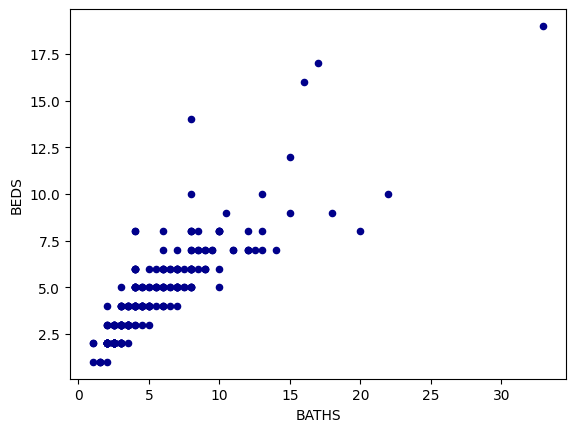

In [ ]:
region_df.groupby(['CITY']).plot.scatter(y='BEDS', x='BATHS', c='DarkBlue')

CITY
Beverly Hills                Axes(0.125,0.11;0.775x0.77)
Beverly Hills Post Office    Axes(0.125,0.11;0.775x0.77)
Hollywood Hills              Axes(0.125,0.11;0.775x0.77)
Los Angeles                  Axes(0.125,0.11;0.775x0.77)
Studio City                  Axes(0.125,0.11;0.775x0.77)
West Hollywood               Axes(0.125,0.11;0.775x0.77)
dtype: object

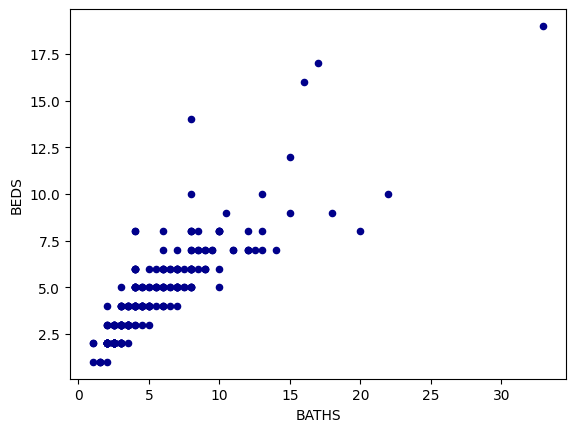

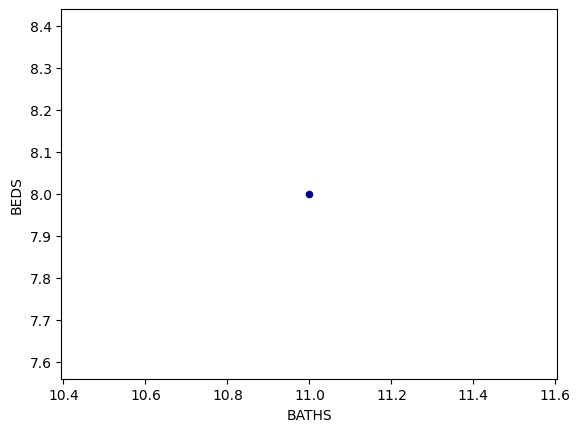

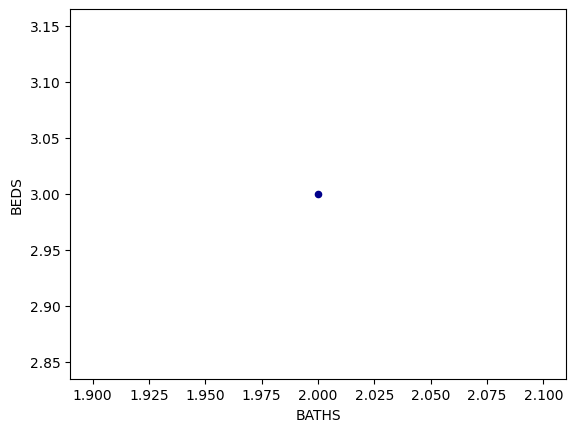

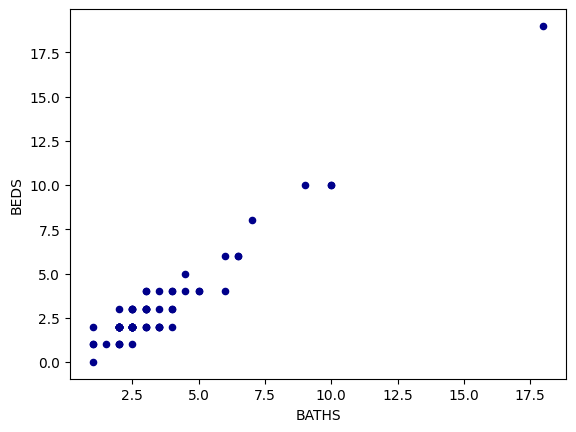

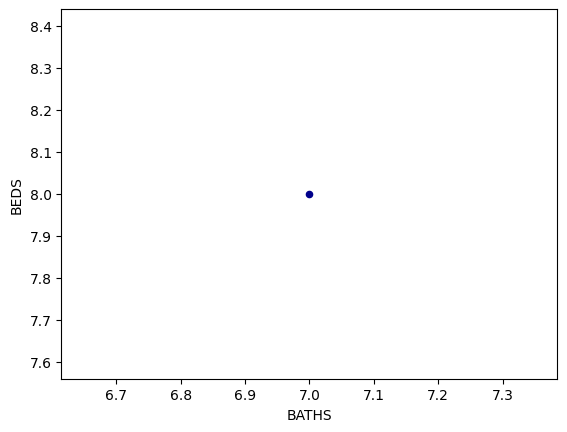

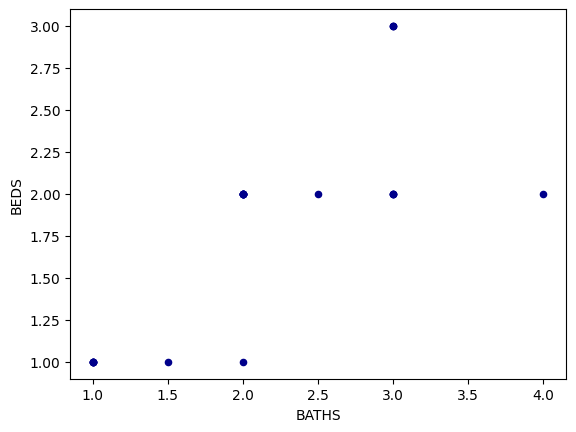

In [ ]:
area_df = df.copy()
area_df.groupby(['CITY']).plot.scatter(y='BEDS', x='BATHS', c='DarkBlue')

CITY
Beverly Hills    Axes(0.125,0.11;0.775x0.77)
dtype: object

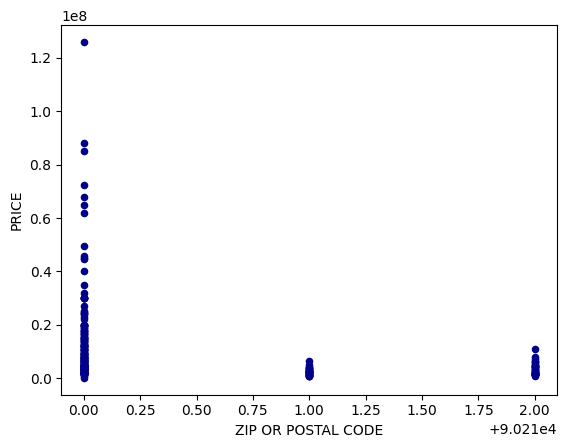

In [ ]:
region_df.groupby(['CITY']).plot.scatter(y='PRICE', x='ZIP OR POSTAL CODE', c='DarkBlue')

In [ ]:
region_df.dropna(subset = ['BEDS', 'BATHS'], inplace=True)

print(region_df)
#region_df.groupby(['CITY']).plot.scatter(y='PRICE', x='BEDS', c='DarkBlue')

       SALE TYPE  SOLD DATE              PROPERTY TYPE  \
1    MLS Listing        NaN  Single Family Residential   
2    MLS Listing        NaN                Condo/Co-op   
5    MLS Listing        NaN  Single Family Residential   
6    MLS Listing        NaN  Single Family Residential   
8    MLS Listing        NaN  Single Family Residential   
..           ...        ...                        ...   
342  MLS Listing        NaN  Single Family Residential   
343  MLS Listing        NaN  Single Family Residential   
345  MLS Listing        NaN  Single Family Residential   
346  MLS Listing        NaN  Single Family Residential   
347  MLS Listing        NaN                Condo/Co-op   

                      ADDRESS           CITY STATE OR PROVINCE  \
1           1633 N Beverly Dr  Beverly Hills                CA   
2          221 S GALE Dr #405  Beverly Hills                CA   
5    1219 Beverly Estates Ter  Beverly Hills                CA   
6              9736 Yoakum Dr  Beverly 

In [ ]:
print(region_df)

None


In [ ]:
from sklearn.linear_model import LinearRegression

x1 = []
y1 = []
z1 = []
bed_x = region_df['BEDS']
value_y = region_df['PRICE']
length = len(bed_x)
length1 = len(value_y)
for z in range(length1):


bed_x = region_df['BEDS']
for x in bed_x:

    x1.append(x)

value_y = region_df['PRICE']
z = 0
for y in value_y:
  if z < 348:
    y1.append(y)
    z = z +1
print(x1)
print(y1)

KeyError: ignored

[2.0, 2.0, 2.0, 3.0, 4.0, 4.0, 2.0, 3.0, 3.0, 5.0, 6.0, 9.0, 3.0, 6.0, 7.0, 2.0, 3.0, 6.0, 8.0, 7.0, 6.0, 4.0, 2.0, 2.0, 5.0, 5.0, 3.0, 4.0, 4.0, 3.0, 4.0, 6.0, 4.0, 6.0, 10.0, 6.0, 8.0, 2.0, 4.0, 5.0, 3.0, 3.0, 3.0, 4.0, 2.0, 4.0, 1.0, 8.0, 2.0, 4.0, 5.0, 4.0, 4.0, 5.0, 6.0, 2.0, 2.0, 3.0, 5.0, 10.0, 5.0, 8.0, 6.0, 6.0, 4.0, 3.0, 2.0, 7.0, 4.0, 4.0, 2.0, 8.0, 3.0, 3.0, 3.0, 6.0, 1.0, 5.0, 3.0, 7.0, 3.0, 6.0, 3.0, 5.0, 16.0, 3.0, 5.0, 4.0, 3.0, 5.0, 2.0, 5.0, 4.0, 3.0, 4.0, 3.0, 4.0, 5.0, 4.0, 5.0, 2.0, 2.0, 5.0, 4.0, 7.0, 7.0, 9.0, 9.0, 7.0, 5.0, 2.0, 7.0, 4.0, 2.0, 3.0, 1.0, 2.0, 2.0, 5.0, 7.0, 2.0, 2.0, 6.0, 7.0, 1.0, 4.0, 1.0, 6.0, 2.0, 6.0, 8.0, 14.0, 6.0, 2.0, 6.0, 4.0, 5.0, 2.0, 2.0, 2.0, 12.0, 4.0, 5.0, 3.0, 2.0, 5.0, 4.0, 3.0, 4.0, 2.0, 5.0, 19.0, 5.0, 3.0, 6.0, 6.0, 3.0, 2.0, 4.0, 8.0, 2.0, 8.0, 2.0, 2.0, 5.0, 4.0, 7.0, 5.0, 6.0, 8.0, 2.0, 2.0, 2.0, 4.0, 5.0, 3.0, 6.0, 5.0, 6.0, 2.0, 6.0, 2.0, 5.0, 4.0, 2.0, 5.0, 4.0, 7.0, 6.0, 8.0, 5.0, 4.0, 7.0, 4.0, 2.0, 3.0, 7.0, 8.0, 7.0

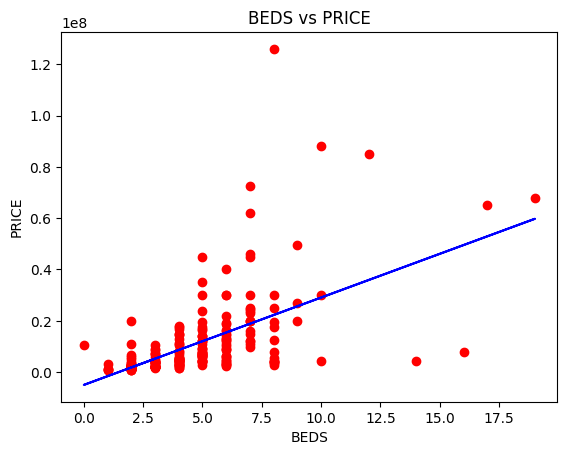

In [ ]:
from sklearn.linear_model import LinearRegression

x1 = []
y1 = []
z= 0
bed_x = region_df['BEDS']
for x in bed_x:
  if z < 348:
    x1.append(x)
    z = z +1
value_y = region_df['PRICE']
z = 0
for y in value_y:
  if z < 348:
    y1.append(y)
    z = z +1
print(x1)
print(y1)

x1 = np.array(x1).reshape(-1,1)
y1 = np.array(y1).reshape(-1,1)
regressor = LinearRegression()
regressor.fit(x1, y1)

plt.scatter(x1, y1, color = 'red')
plt.plot(x1, regressor.predict(x1), color = 'blue')
plt.title('BEDS vs PRICE')
plt.xlabel('BEDS')
plt.ylabel('PRICE')
plt.show()

[2.0, 2.0, 2.0, 3.0, 4.0, 4.0, 2.0, 3.0, 3.0, 5.0, 6.0, 9.0, 3.0, 6.0, 7.0, 2.0, 3.0, 6.0, 8.0, 7.0, 6.0, 4.0, 2.0, 2.0, 5.0, 5.0, 3.0, 4.0, 4.0, 3.0, 4.0, 6.0, 4.0, 6.0, 10.0, 6.0, 8.0, 2.0, 4.0, 5.0, 3.0, 3.0, 3.0, 4.0, 2.0, 4.0, 1.0, 8.0, 2.0, 4.0, 5.0, 4.0, 4.0, 5.0, 6.0, 2.0, 2.0, 3.0, 5.0, 10.0, 5.0, 8.0, 6.0, 6.0, 4.0, 3.0, 2.0, 7.0, 4.0, 4.0, 2.0, 8.0, 3.0, 3.0, 3.0, 6.0, 1.0, 5.0, 3.0, 7.0, 3.0, 6.0, 3.0, 5.0, 16.0, 3.0, 5.0, 4.0, 3.0, 5.0, 2.0, 5.0, 4.0, 3.0, 4.0, 3.0, 4.0, 5.0, 4.0, 5.0, 2.0, 2.0, 5.0, 4.0, 7.0, 7.0, 9.0, 9.0, 7.0, 5.0, 2.0, 7.0, 4.0, 2.0, 3.0, 1.0, 2.0, 2.0, 5.0, 7.0, 2.0, 2.0, 6.0, 7.0, 1.0, 4.0, 1.0, 6.0, 2.0, 6.0, 8.0, 14.0, 6.0, 2.0, 6.0, 4.0, 5.0, 2.0, 2.0, 2.0, 12.0, 4.0, 5.0, 3.0, 2.0, 5.0, 4.0, 3.0, 4.0, 2.0, 5.0, 19.0, 5.0, 3.0, 6.0, 6.0, 3.0, 2.0, 4.0, 8.0, 2.0, 8.0, 2.0, 2.0, 5.0, 4.0, 7.0, 5.0, 6.0, 8.0, 2.0, 2.0, 2.0, 4.0, 5.0, 3.0, 6.0, 5.0, 6.0, 2.0, 6.0, 2.0, 5.0, 4.0, 2.0, 5.0, 4.0, 7.0, 6.0, 8.0, 5.0, 4.0, 7.0, 4.0, 2.0, 3.0, 7.0, 8.0, 7.0

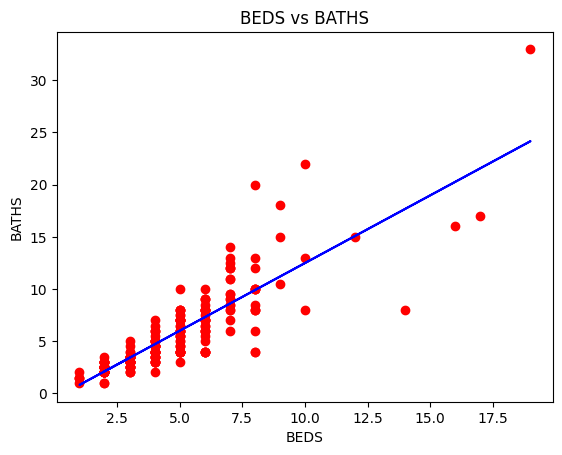

In [ ]:
from sklearn.linear_model import LinearRegression

x1 = []
y1 = []
z= 0
bed_x = region_df['BEDS']
for x in bed_x:
  if z < 348:
    x1.append(x)
    z = z +1
value_y = region_df['BATHS']
z = 0
for y in value_y:
  if z < 348:
    y1.append(y)
    z = z +1
print(x1)
print(y1)

x1 = np.array(x1).reshape(-1,1)
y1 = np.array(y1).reshape(-1,1)
regressor = LinearRegression()
regressor.fit(x1, y1)

plt.scatter(x1, y1, color = 'red')
plt.plot(x1, regressor.predict(x1), color = 'blue')
plt.title('BEDS vs BATHS')
plt.xlabel('BEDS')
plt.ylabel('BATHS')
plt.show()

[2.0, 2.0, 2.0, 3.0, 4.0, 4.0, 2.0, 3.0, 3.0, 5.0, 6.0, 9.0, 3.0, 6.0, 7.0, 2.0, 3.0, 6.0, 8.0, 7.0, 6.0, 4.0, 2.0, 2.0, 5.0, 5.0, 3.0, 4.0, 4.0, 3.0, 4.0, 6.0, 4.0, 6.0, 10.0, 6.0, 8.0, 2.0, 4.0, 5.0, 3.0, 3.0, 3.0, 4.0, 2.0, 4.0, 1.0, 8.0, 2.0, 4.0, 5.0, 4.0, 4.0, 5.0, 6.0, 2.0, 2.0, 3.0, 5.0, 10.0, 5.0, 8.0, 6.0, 6.0, 4.0, 3.0, 2.0, 7.0, 4.0, 4.0, 2.0, 8.0, 3.0, 3.0, 3.0, 6.0, 1.0, 5.0, 3.0, 7.0, 3.0, 6.0, 3.0, 5.0, 16.0, 3.0, 5.0, 4.0, 3.0, 5.0, 2.0, 5.0, 4.0, 3.0, 4.0, 3.0, 4.0, 5.0, 4.0, 5.0, 2.0, 2.0, 5.0, 4.0, 7.0, 7.0, 9.0, 9.0, 7.0, 5.0, 2.0, 7.0, 4.0, 2.0, 3.0, 1.0, 2.0, 2.0, 5.0, 7.0, 2.0, 2.0, 6.0, 7.0, 1.0, 4.0, 1.0, 6.0, 2.0, 6.0, 8.0, 14.0, 6.0, 2.0, 6.0, 4.0, 5.0, 2.0, 2.0, 2.0, 12.0, 4.0, 5.0, 3.0, 2.0, 5.0, 4.0, 3.0, 4.0, 2.0, 5.0, 19.0, 5.0, 3.0, 6.0, 6.0, 3.0, 2.0, 4.0, 8.0, 2.0, 8.0, 2.0, 2.0, 5.0, 4.0, 7.0, 5.0, 6.0, 8.0, 2.0, 2.0, 2.0, 4.0, 5.0, 3.0, 6.0, 5.0, 6.0, 2.0, 6.0, 2.0, 5.0, 4.0, 2.0, 5.0, 4.0, 7.0, 6.0, 8.0, 5.0, 4.0, 7.0, 4.0, 2.0, 3.0, 7.0, 8.0, 7.0

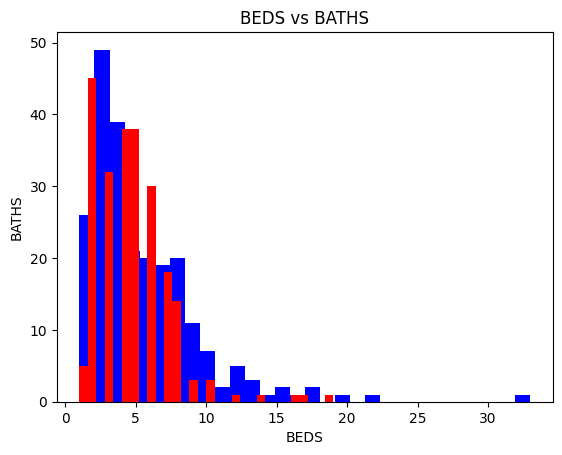

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

x1 = []
y1 = []
z= 0
bed_x = region_df['BEDS']
for x in bed_x:
  if z < 348:
    x1.append(x)
    z = z +1
value_y = region_df['BATHS']
z = 0
for y in value_y:
  if z < 348:
    y1.append(y)
    z = z +1
print(x1)
print(y1)

plt.hist(y1, 30, color= 'blue')
plt.hist(x1, 30, color= 'red')

plt.title('BEDS vs BATHS')
plt.xlabel('BEDS')
plt.ylabel('BATHS')
plt.show()

For debugging purposes...

In [ ]:
!pip install -Uqq ipdb
import ipdb
%pdb on

Automatic pdb calling has been turned ON


In [ ]:
# scrape redfin data

region_id = pd.read_csv('/content/drive/MyDrive/602-project/Region_id.csv')
# region_id = region_id[region_id.location.isin(['Rowland Heights', 'Arcadia', 'Walnut', 'El Monte'])].reset_index(drop=True)
region_id = region_id[region_id.location.isin(['Beverly Hills', 'Los Angeles', 'Santa Monica', 'Long Beach'])].reset_index(drop=True)

n = region_id.shape[0]

In [ ]:
master = pd.DataFrame(columns = ['month', 'sale_volume', 'price_med', 'location'])
for i in range(n):
    # download all the historical sales data
    data = pd.DataFrame()
    # 2 Bedrooms or below
    repeat = 1
    while repeat:
        try:
            print('We are working on ' + region_id['location'][i] + ' : bedroom ' + str(2))
            url = r'https://www.redfin.com/stingray/api/gis-csv?al=1&market=socal&max_num_beds=2&min_stories=1&num_home=20000&ord=redfin-recommended-asc&page_number=1&region_id={}&region_type=6&sold_within_days=36500&status=9&uipt=1,2,3,4,5,6&v=8'.format(region_id['region_id'][i])
            print(url)
            page = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).content
            time.sleep(1+random.random())
            s = pd.read_csv(io.StringIO(page.decode('utf-8')))
            s.drop(s[s['CITY'] != str(region_id['location'][i])].index, inplace=True)
            ipdb.set_trace(context=3)
            repeat = 0
        except:
            repeat = 1

    data = data.append(s, ignore_index=True)
    # 3/4/5/6 Bedrooms
    for x in range(3,7):
        repeat = 1
        while repeat:
            try:
                try:
                    print('We are working on ' + region_id['location'][i] + ' : bedroom ' + str(x))
                    url = r'https://www.redfin.com/stingray/api/gis-csv?al=1&market=socal&max_num_beds={}&min_stories=1&num_beds={}&num_home=20000&ord=redfin-recommended-asc&page_number=1&region_id={}&region_type=6&sold_within_days=36500&status=9&uipt=1,2,3,4,5,6&v=8'.format(x, x, region_id['region_id'][i])
                    print(url)
                    page = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).content
                    time.sleep(1+random.random())
                    s = pd.read_csv(io.StringIO(page.decode('utf-8')))
                    repeat = 0

                except:
                    print('We are working on ' + region_id['location'][i] + ' : bedroom ' + str(x))
                    url = r'https://www.redfin.com/stingray/api/gis-csv?al=1&market=socal&max_num_beds={}&min_stories=1&num_beds={}&num_home=20000&ord=redfin-recommended-asc&page_number=1&region_id={}&region_type=6&sold_within_days=36500&status=9&uipt=1,2,3,4,5,6&v=8'.format(x, x, region_id['region_id'][i])
                    print(url)
                    s = pd.read_csv(url)
                    time.sleep(1+random.random())
                    repeat = 0
            except:
                repeat = 1

        data = data.append(s, ignore_index=True)

    data.to_csv(r'/content/drive/MyDrive/MSML602-FinalProject/rawdata/{}.csv'.format(region_id['location'][i]), index = False)
    # need to clean data
    # by month/property type: (1) number of house sold (2) median price/sqft
    data = data[data['CITY']==region_id['location'][i]]
    data = data[data['PROPERTY TYPE']=='Single Family Residential']

    data = data[data['SOLD DATE'].isnull()==False]

    data['SOLD DATE2'] = pd.to_datetime(data['SOLD DATE'], format='%B-%d-%Y')
    data['year'] = pd.DatetimeIndex(data['SOLD DATE2']).year
    data['month'] = pd.DatetimeIndex(data['SOLD DATE2']).month
    data['SOLD DATE3'] = data['year'].astype(str) + '-' + data['month'].astype(str) + '-' + '01'
    data['SOLD DATE3'] = pd.to_datetime(data['SOLD DATE3'], format='%Y-%m-%d').dt.date

    # data['SOLD DATE3'] = data['SOLD DATE2'] + pd.offsets.MonthBegin(-1) # this is a trick of shortcout to change date
    table = data[['SOLD DATE3', '$/SQUARE FEET']].groupby(['SOLD DATE3']).agg(['count', 'median']).reset_index()
    table.columns = ['month', 'sale_volume', 'price_med']
    table['location'] = region_id['location'][i]
    master = master.append(table)

print('Finish downloading Redfin data!')

master['month'] = master['month'].astype(str)
master['sale_volume'] = master['sale_volume'].astype(int)

Finish downloading Redfin data!


In [ ]:
master.head()

,month,sale_volume,price_med,location


In [ ]:
from fredapi import Fred

fred = Fred(api_key='3e45db934f364bc329aca420c85fa04e')
# extract S&P/Case-Shiller CA-Los Angeles Home Price Index (LXXRNSA)
# https://fred.stlouisfed.org/series/LXXRNSA
la_hpi_raw = fred.get_series('LXXRNSA')
la_hpi = la_hpi_raw.to_frame()
la_hpi.columns = ['hpi']
la_hpi['month'] = la_hpi.index
la_hpi = la_hpi.reset_index(drop = True)
la_hpi['month'] = la_hpi.apply(lambda x: x['month'].date(), axis = 1)

weights = np.array([0.2, 0.3, 0.5])
sum_weights = np.sum(weights)
# compute weighted MA from latest 3 months
la_hpi['hpi'] = la_hpi['hpi'].rolling(3).apply(lambda x: np.sum(weights*x) / sum_weights, raw=False).reset_index(drop = True)
month_diff = datetime.now().month - la_hpi['month'].max().month
# reset the month variable so that it can be merged with sales data
la_hpi['month'] = la_hpi['month'] + pd.DateOffset(months=month_diff)
la_hpi['month'] = la_hpi.apply(lambda x: x['month'].date(), axis = 1)

# 30-Year Fixed Rate Mortgage Average in the United States (MORTGAGE30US)
# https://fred.stlouisfed.org/series/MORTGAGE30US
mort_rate_30yrs_raw = fred.get_series('MORTGAGE30US')

mort_rate_30yrs = mort_rate_30yrs_raw.to_frame()
mort_rate_30yrs.columns = ['mort_rate']
mort_rate_30yrs['date'] = mort_rate_30yrs.index
mort_rate_30yrs = mort_rate_30yrs.reset_index(drop = True)
mort_rate_30yrs['date'] = mort_rate_30yrs.apply(lambda x: x['date'].date(), axis = 1)
mort_rate_30yrs['year'] = mort_rate_30yrs.apply(lambda x: x['date'].year, axis = 1)
mort_rate_30yrs['month'] = mort_rate_30yrs.apply(lambda x: x['date'].month, axis = 1)
mort_rate_30yrs = mort_rate_30yrs.groupby(['year', 'month'])['mort_rate'].mean().reset_index()
mort_rate_30yrs['month'] = mort_rate_30yrs.apply(lambda x: date(int(x['year']), int(x['month']), 1), axis = 1)
mort_rate_30yrs = mort_rate_30yrs.drop(columns = ['year'])

In [ ]:
# import sales data from redfin
data = pd.DataFrame()
for i in ['Arcadia', 'El Monte', 'Rowland Heights', 'Walnut']:
    one = pd.read_csv(r'/content/drive/MyDrive/602-project/rawdata/{}.csv'.format(i))
    one = one[one['CITY'] == i]
    data = data.append(one)

data.rename(columns = {'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)':'URL'}, inplace = True)
data = data[~data['CITY'].isnull()]
data = data[data['CITY'].isin(['Arcadia', 'El Monte', 'Walnut', 'Rowland Heights'])]
data = data[data['PROPERTY TYPE'].str.contains('Single|Condo|Townhouse')]
data = data[~data['SOLD DATE'].isnull()]
data.rename(columns = {'ZIP OR POSTAL CODE': 'ZIP',
                          'HOA/MONTH': 'HOA',
                          'PROPERTY TYPE': 'PROPERTY_TYPE',
                          'SQUARE FEET': 'SQUARE_FEET',
                          'LOT SIZE': 'LOT_SIZE'
                          }, inplace = True)


FileNotFoundError: ignored

Clean Redfin Data to proper data types

In [ ]:
# start cleaning redfine data
# PRICE: Y
data = data[~data['PRICE'].isnull()]
data['PRICE'] = data['PRICE'].astype('int')

# SOLD DATE: month
data['SOLD DATE2'] = pd.to_datetime(data['SOLD DATE'], format='%B-%d-%Y')
data['year'] = pd.DatetimeIndex(data['SOLD DATE2']).year
data['mth'] = pd.DatetimeIndex(data['SOLD DATE2']).month
data['month'] = data.apply(lambda x: date(int(x['year']), int(x['mth']), 1), axis = 1)

# YEAR BUILT: age
# age should be the age on the sold date
data['age'] = data['year'] - data['YEAR BUILT']

# HOA/MONTH: if nan, set it to be $0.01
data['HOA'] = data.apply(lambda x: 0.01 if (np.isnan(x['HOA']) & bool(re.findall('Single', x['PROPERTY_TYPE'])))  else  x['HOA'], axis =1)

# LOT SIZE: change LOT SIZE to be  SQUARE FEET for non-single house
data['LOT_SIZE'] = data.apply(lambda x: x['LOT_SIZE'] if re.findall('Single', x['PROPERTY_TYPE']) else  x['SQUARE_FEET']    , axis =1)

# ZIP
data = data[~data['ZIP'].isnull()]
data['ZIP'] = data['ZIP'].astype('int')
zip_keep = data['ZIP'].value_counts()
zip_keep = zip_keep[zip_keep/len(data) > 0.01].index
data = data[data['ZIP'].isin(zip_keep)]

data['ZIP'].value_counts(dropna = False)

keep_var = ['PRICE', 'PROPERTY_TYPE', 'CITY', 'ZIP', 'BEDS', 'BATHS', 'SQUARE_FEET', 'LOT_SIZE', 'age', 'HOA', 'year', 'mth', 'month']

data = data[keep_var]

df = data.merge(mort_rate_30yrs, on = 'month', how = 'left')
df = df.merge(la_hpi, on = 'month', how = 'left')
df.columns = [i.lower()  for i in df.columns]
df.head()

KeyError: ignored

In [ ]:
# vectorize variables
df = pd.get_dummies(df, columns = ['property_type','zip', 'mth', 'city'])

X = df.drop(columns = ['price', 'year', 'month'])
y = df['price']

# split data into training and testing
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape, X_val.shape

KeyError: ignored

## **XGBoost Model**

In [ ]:
# need to create function to return accuracy of GridSearchCV
def tuning_para(alg, tuning_para):
    gsearch = GridSearchCV(estimator=alg,
                           param_grid = tuning_para,
                           scoring=make_scorer(mean_squared_error, squared=False, greater_is_better=False),
                           #scoring=make_scorer(r2_score),
                           n_jobs=-1,
                           cv=5,
                           verbose = 2)

    gsearch.fit(X_train, y_train)
    print(gsearch.best_estimator_.get_params())
    print('')
    for i, j in zip(gsearch.cv_results_['params'], gsearch.cv_results_['mean_test_score']):
        print(i, int(j) if abs(j)>1 else j)
    print('')
    # predict test data
    predictions = gsearch.predict(X_val)

    print('Mean-Absolute-Error(MAE): {}'.format(mean_absolute_error(y_val, predictions)))
    print('Root-Mean-Squared-Error(RMSE): {}'.format(mean_squared_error(y_val, predictions, squared = False)))
    print('Mean absolute percentage error (MAPE): {}'.format(mean_absolute_percentage_error(y_val, predictions)))
    print('R2: {}'.format(r2_score(y_val, predictions)))
    print([f'{key}: {gsearch.best_estimator_.get_params().get(key)}' for key in tuning_para.keys()])

    return gsearch

In [ ]:
para_test = {}
xgb_model = XGBRegressor(objective = 'reg:squarederror', random_state =27)
xgb_model_deploy = tuning_para(xgb_model, para_test)

NameError: ignored

**Hupertuning Parameters for Final Model**

In [ ]:
# Test learning rate and n_estimator first
para_test = {'learning_rate':[0.01, 0.05, 0.1, 0.2],
             'n_estimators':[100, 200, 300]}
xgb_model = XGBRegressor(objective = 'reg:squarederror', random_state =27)
xgb_model_deploy = tuning_para(xgb_model, para_test)

NameError: ignored

In [ ]:
# Tune max_depth and min_child_weight
para_test = {
 'max_depth':range(3,10,2), # max depth of each tree
 'min_child_weight':range(1,6,2) # cover
}

xgb_model = XGBRegressor(objective = 'reg:squarederror',
                         random_state =27,
                         learning_rate = 0.05,
                         n_estimators = 300
                         )
xgb_model_deploy = tuning_para(xgb_model, para_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 27, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
**************************************
{'max_de

In [ ]:
# Tune gamma
para_test= {
    'gamma':[i/10.0 for i in range(0,5)] # the min gain requried to split
}
xgb_model = XGBRegressor(objective = 'reg:squarederror',
                         random_state =27,
                         learning_rate = 0.05,
                         n_estimators = 300,
                         max_depth = 5,
                         min_child_weight = 5
                         )
xgb_model_deploy = tuning_para(xgb_model, para_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 27, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
**************************************
{'gamma': 

In [ ]:
# Tune subsample and colsample_bytree
para_test = {
 'subsample':[i/10.0 for i in range(6,10)],  # number of samples allowed
 'colsample_bytree':[i/10.0 for i in range(6,10)] # number of fields allowed in each tree
}
xgb_model = XGBRegressor(objective = 'reg:squarederror',
                         random_state =27,
                         learning_rate = 0.05,
                         n_estimators = 300,
                         max_depth = 5,
                         min_child_weight = 5,
                         gamma = 0
                         )
xgb_model_deploy = tuning_para(xgb_model, para_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 27, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.6, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
**************************************
{'colsample_b

**Train Final Model**

<ipython-input-37-830dfc3fc270>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgb_model_deploy = xgb_model.fit(X_train.append(X_val), y_train.append(y_val))
<ipython-input-37-830dfc3fc270>:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgb_model_deploy = xgb_model.fit(X_train.append(X_val), y_train.append(y_val))
<ipython-input-37-830dfc3fc270>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction  = xgb_model_deploy.predict(X_train.append(X_val))
<ipython-input-37-830dfc3fc270>:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  st_dev = (mean_squared_error(prediction, y_train.append(y_val)) ** 0.5 ).round(-3)


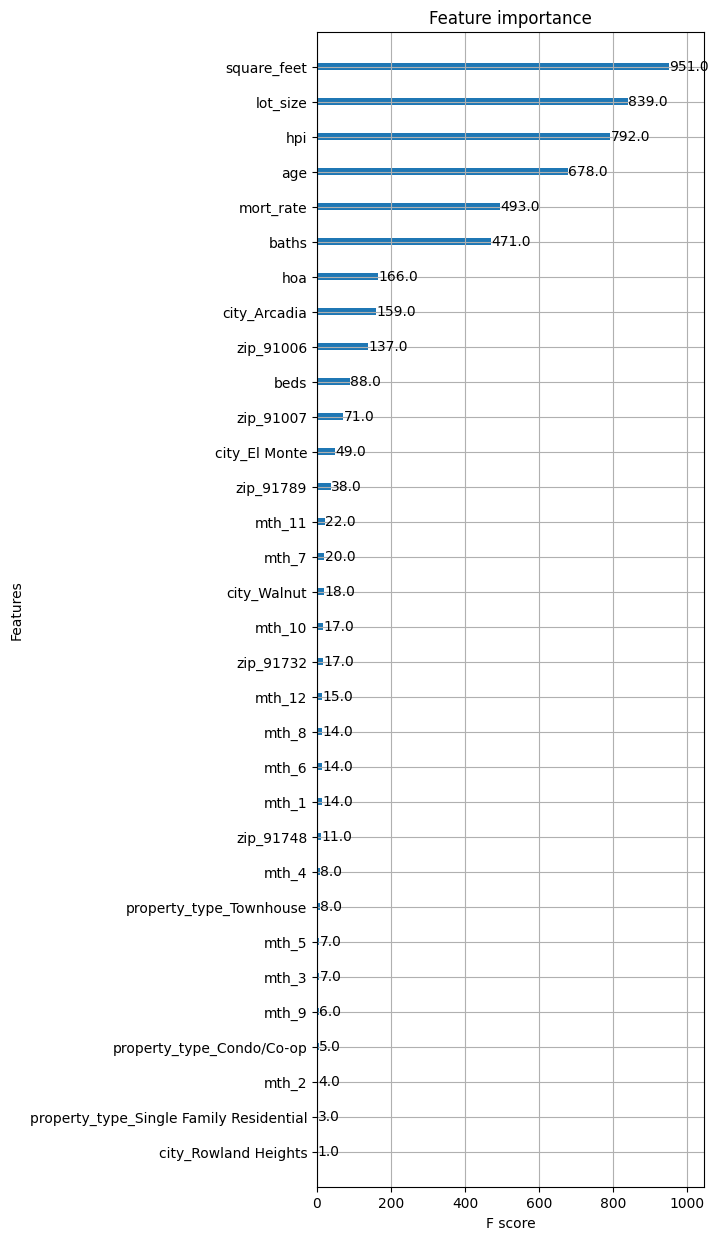

In [ ]:
# final model
xgb_model = XGBRegressor(objective = 'reg:squarederror',
                         random_state =27,
                         learning_rate = 0.05,
                         n_estimators = 300,
                         max_depth = 5,
                         min_child_weight = 5,
                         gamma = 0,
                         colsample_bytree = 0.9,
                         subsample = 0.6
                         )

xgb_model_deploy = xgb_model.fit(X_train.append(X_val), y_train.append(y_val))
prediction  = xgb_model_deploy.predict(X_train.append(X_val))

st_dev = (mean_squared_error(prediction, y_train.append(y_val)) ** 0.5 ).round(-3)
xgb_model_deploy.st_dev = st_dev

with open(r'/content/drive/MyDrive/MSML602-FinalProject/xgb_model_deploy.pickle', 'wb') as f:
    pickle.dump(xgb_model_deploy, f)

plt.rcParams["figure.figsize"] = (5,15)
plot_importance(xgb_model_deploy)
plt.show()

## Run DASH App

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import dash_bootstrap_components as dbc

<ipython-input-39-630be2e5bca3>:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-39-630be2e5bca3>:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


Clean up Dataframe

In [ ]:
df = master.copy()
df.sort_values(by=['location', 'month'], ignore_index=True, inplace=True)

weights = np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
sum_weights = np.sum(weights)
# compute weighted Moving average [need to move this part to scraping program]
df['price_med_ma6'] = df.groupby(['location'])['price_med'].rolling(6).apply(lambda x: np.sum(weights*x) / sum_weights, raw=False).reset_index(drop = True).round(0)
df['year'] = df.month.str.slice(0,4).astype(int)
df['price_1yr_b4'] = df.groupby('location')['price_med_ma6'].shift(12)
df['yty_per_diff'] = df.apply(lambda x: x['price_med_ma6']/ x['price_1yr_b4'] - 1 , axis =1)

all_locations = df.location.unique()
all_locations

array(['Arcadia', 'El Monte', 'Rowland Heights', 'Walnut'], dtype=object)

In [ ]:
external_stylesheets = [dbc.themes.BOOTSTRAP]
app = dash.Dash( external_stylesheets=external_stylesheets)

app.title = 'Housing Price Dashboard'
server = app.server

# load the ml model
xgb_model_deploy = pickle.load(open('/content/drive/MyDrive/MSML602-FinalProject/xgb_model_deploy.pickle', 'rb'))

prediction_col1 =  dbc.Col([
                html.Br(),
                dbc.Row([html.H3(children='Predict Housing Price')]),
                dbc.Row([
                    dbc.Col(html.Label(children='City and Zip:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dcc.Dropdown(
                        id='city_zip',
                        options=[
                            {'label': 'Arcadia - 91006', 'value': 'Arcadia - 91006'},
                            {'label': 'Arcadia - 91007', 'value': 'Arcadia - 91007'},
                            {'label': 'El Monte - 91731', 'value': 'El Monte - 91731'},
                            {'label': 'El Monte - 91732', 'value': 'El Monte - 91732'},
                            {'label': 'El Monte - 91733', 'value': 'El Monte - 91733'},
                            {'label': 'Rowland Heights - 91748', 'value': 'Rowland Heights - 91748'},
                            {'label': 'Walnut - 91789', 'value': 'Walnut - 91789'},
                        ],
                        value='Walnut - 91789',
                        style = {"width": "50%", 'padding': '5px 0px 5px 10px', 'display': 'inline-block'}
                    )
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Beds:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dcc.Dropdown(
                        id='beds',
                        options=[
                            {'label': '1', 'value': 1},
                            {'label': '2', 'value': 2},
                            {'label': '3', 'value': 3},
                            {'label': '4', 'value': 4},
                            {'label': '5', 'value': 5},
                            {'label': '6', 'value': 6},
                        ],
                        style = {"width": "30%", 'padding': '5px 0px 5px 10px' , 'display': 'inline-block'},
                        value=4
                    )
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Baths:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dcc.Dropdown(
                        id='baths',
                        options=[
                            {'label': '1', 'value': 1},
                            {'label': '1.5', 'value': 1.5},
                            {'label': '2', 'value': 2},
                            {'label': '2.5', 'value': 2.5},
                            {'label': '3', 'value': 3},
                            {'label': '3.5', 'value': 3.5},
                            {'label': '4', 'value': 4},
                            {'label': '5', 'value': 5},
                            {'label': '6', 'value': 6},
                        ],
                        style = {"width": "30%", 'padding': '5px 0px 5px 10px', 'display': 'inline-block' },
                        value=2.5
                    )
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Property Type:'), width={"order": "first"}, style = {'padding': '5px 0px 5px 0px'}),
                    dbc.RadioItems(
                        id='prop_type',
                        options=[
                            {'label': 'Single Family Residential', 'value': 'Single Family Residential'},
                            {'label': 'Condo/Co-op', 'value': 'Condo/Co-op'},
                            {'label': 'Townhouse', 'value': 'Townhouse'}
                            ],
                        style = {"width": "60%", 'padding': '5px 0px 10px 10px', 'display': 'inline-block' },
                        value = 'Single Family Residential',
                        labelStyle={'display': 'inline-block'},
                        inline=True # arrange list horizontally
                    )
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Square Feet:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dbc.Col(dbc.Input(id='sf', type='text', value = '1980', style = {'padding': '5px 0px 5px 10px', 'width': '200px'}))
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Lot Size:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dbc.Col(dbc.Input(id='ls', type='text', value = '6000', style = {'padding': '5px 0px 5px 10px', 'width': '200px'}))
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Year:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dbc.Col(dbc.Input(id='year', type='text', value = '1977', style = {'padding': '5px 0px 5px 10px', 'width': '200px'}))
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='HOA:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dbc.Col(dbc.Input(id='hoa', type='text', value = '0', style = {'padding': '5px 0px 5px 10px', 'width': '200px'}))
                ]),
                html.Br(),
                dbc.Row([dbc.Button('Submit', id='submit-val', n_clicks=0, color="primary")]),
                html.Br(),
                dbc.Row([html.Div(id='container-button-basic')])
            ], style = {'padding': '0px 0px 0px 150px'})

prediction_col2 =  dbc.Col([ html.Br(), html.Div(dcc.Graph(id='hist-graph'))], style = {'padding': '0px 0px 0px 0px'})

app.layout = html.Div([
    html.H1(children='Housing Price Index Dashboard'),
    html.Div(children='''Housing price is constructed using sales data from Redfin.'''),
    html.Div(children=f'''Last Updated: {datetime.now()}'''),
    html.Br(),

    dcc.Tabs(style = {'width': '100%'}, children=[
        dcc.Tab(label='Housing Price Prediction', children = [
            dbc.Row([prediction_col1, prediction_col2])
        ])
    ]) # end of all tabs

], style = {'padding': '20px'}) # the end of app.layout

# create call back for prediction
@app.callback(
    Output('container-button-basic', 'children'),
    Output('hist-graph', 'figure'),
    Input('submit-val', 'n_clicks'),
    State('city_zip', 'value'),
    State('beds', 'value'),
    State('baths', 'value'),
    State('prop_type', 'value'),
    State('sf', 'value'),
    State('ls', 'value'),
    State('year', 'value'),
    State('hoa', 'value'))

def update_output(n_clicks, city_zip, beds, baths, prop_type, sf, ls, year, hoa):
    if int(hoa) == 0:
        hoa = 0.01
    else:
        hoa = float(hoa)

    city_string = city_zip.split(' - ')[0]
    zip_string = city_zip.split(' - ')[1]


    query = pd.DataFrame({'beds': beds,
                        'baths':baths,
                        'square_feet':float(sf),
                        'lot_size':float(ls),
                        'age':2021-int(year),
                        'hoa':hoa,
                        'mort_rate':2.92,
                        'hpi': 334,
                        'property_type_Condo/Co-op':0,
                        'property_type_Single Family Residential':0,
                        'property_type_Townhouse':0,
                        'zip_91006':0,
                        'zip_91007':0,
                        'zip_91731':0,
                        'zip_91732':0,
                        'zip_91733':0,
                        'zip_91748':0,
                        'zip_91789':0,
                        'mth_1':0,
                        'mth_2':0,
                        'mth_3':0,
                        'mth_4':0,
                        'mth_5':1,
                        'mth_6':0,
                        'mth_7':0,
                        'mth_8':0,
                        'mth_9':0,
                        'mth_10':0,
                        'mth_11':0,
                        'mth_12':0,
                        'city_Arcadia':0,
                        'city_El Monte':0,
                        'city_Rowland Heights':0,
                        'city_Walnut':0
                        }, index = [0])

    query[f'city_{city_string}'] = 1
    query[f'zip_{zip_string}'] = 1
    query[f'property_type_{prop_type}'] = 1

    prediction = int(xgb_model_deploy.predict(query)[0].round(-3))
    output = int(prediction)

    pos = prediction
    scale = xgb_model_deploy.st_dev
    size = 200
    np.random.seed(123)
    values = np.random.normal(pos, scale, size)
    his_df = pd.DataFrame(values, columns = ['Price'])

    p_25 = int((pos-0.67*scale).round(-3))
    p_50 = pos
    p_75 = int((pos+0.67*scale).round(-3))
    dollar_per_sq_ft = int(p_50/query['square_feet'])

    fig = px.histogram(his_df, x = 'Price', histnorm ='percent', nbins = 20, width = 00, height  = 600)
    fig.add_vline(x=p_25, line_width=3, line_dash="dash", line_color="green", annotation_text=f"25th Percentile: ${p_25:,}", annotation_position="top left")
    fig.add_vline(x=p_75, line_width=3, line_dash="dash", line_color="green", annotation_text=f"75th Percentile: ${p_75:,}", annotation_position="top right")
    fig.add_vline(x=p_50, line_width=3, line_dash="dash", line_color="green", annotation_text=f"50th Percentile (Median Price): ${p_50:,}", annotation_position="top")
    fig.add_vrect(x0=p_25, x1=p_75, line_width=0, fillcolor="red", opacity=0.2)

    return f'The estimated median price is ${p_50:,} (${dollar_per_sq_ft} psf).' , fig


print('Current time: Run App : ' + str(datetime.now()))
# run the app
if __name__ == '__main__':
    # app.run_server(debug=True)
    app.run_server(host="127.0.0.1", port=8050)

Current time: Run App : 2023-12-08 03:30:51.483108


<IPython.core.display.Javascript object>

In [ ]:
# Open app
js_code = f"window.open('{eval_js('google.colab.kernel.proxyPort(8050)')}');"
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>